# Final Project: Comparing the cities of Toronto and New York

## Introduction/ Business Project

New York City and Toronto are two similar cities in the sense that they are both in the same continent, not very far from each other, multicultural cities and financial hubs in their respective countries. In this project our aim is to compare the two cities' neighborhoods using the Foursquare API to see how similar/ dissimilar they are. We will compare the two cities using their neighborhoods venues to cluster them and then analyse the results to see similarities that brought different neighborhoods to be clustered together or not. 
Since the tw cities are very different in size (New York City is more than twice the size of Toronto), we will mainly focus on the proportion of neighborhoods that end up in the same clusters rather than the numbers. 
This project could be of interest to people who are from either of the two cities and looking into relocating to the other city, for instance, businesses present in one of the cities and looking into opening into the other city etc...

## Methodology

### Data collection and preparation 

For this project we will use two main sources besides the foursquare API: 
- For the city of Toronto, we will use the data from the Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and a file containing the location of each of the neighborhoods (latitude and longitudes) http://cocl.us/Geospatial_data'

- For the City of New York we will use the Json file from the website: https://geo.nyu.edu/catalog/nyu_2451_34572

Using these two soursces we will extract the Borough and neighborhoods of each of the two cities and merge them into one dataframe, keeping the name of the city in one column. 

The foursquare API will then be used to obtain 100 venues within a radius of 500 miles of each of the neighborhoods. 

These will then be added to the dataframe to then be used for the clustering of the neighborhoods. 



In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

#### Toronto data

In [8]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df= pd.read_html(url, header=0)[0]

#Renaming the column Postal Code
df.rename(columns={"Postal Code": "PostalCode"}, inplace=True)

#Removing the rows with 'Not assigned' Borough and reseting the indices
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [9]:

#Loading the file containing the geaspacial data into a dataframe
url1='http://cocl.us/Geospatial_data'
df1=pd.read_csv(url1)

#Renaming column 'Postal Code'
df1.rename(columns={"Postal Code": "PostalCode"}, inplace=True)

df1.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:


#Merging the two dataframes to obtain one dataframe with location data for each neighborhood
df_toronto=pd.merge(df,df1, on="PostalCode",right_index=True, left_index=True)

#Droping the PostalCode Column as, it is no longer needed:
df_toronto.drop(['PostalCode'], axis=1, inplace=True)

df_toronto.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.806686,-79.194353
1,North York,Victoria Village,43.784535,-79.160497
2,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711
3,North York,"Lawrence Manor, Lawrence Heights",43.770992,-79.216917
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.773136,-79.239476


Getting the coordinates of Toronto with the geolocator package:

In [11]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude_t = location.latitude
longitude_t = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_t, longitude_t))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


A map to view the neighborhoods of Toronto:

In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_t, longitude_t], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### New York data

In [13]:
pip install wget


The following command must be run outside of the IPython shell:

    $ pip install wget

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [14]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [15]:
#Loading json file containing NY city data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [16]:
# Extracting the relevant information from the file 
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_NY = pd.DataFrame(columns=column_names)


In [17]:
#looping through the data and filing the NY neighborhood data
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_NY = df_NY.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [18]:
df_NY.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


The geographical coordinates of New York City with geolocator:

In [19]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_ny = location.latitude
longitude_ny = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude_ny, longitude_ny))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [20]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_NY['Latitude'], df_NY['Longitude'], df_NY['Borough'], df_NY['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

We now have the two dataframes ready and can use the foursquare API to get the venues for each of the neighborhoods. We will add a column with the name of each of the two cities before merging the two dataframes

In [21]:
df_NY.shape

(306, 4)

In [22]:
df_toronto.shape

(103, 4)

In [23]:
df_toronto['City']=['Toronto']*df_toronto.shape[0]

In [24]:
df_NY['City']=['New York']*df_NY.shape[0]

We can now merge the two dataframes

In [25]:
df_NY_toronto=pd.concat([df_toronto, df_NY],sort=True, ignore_index=True)

In [26]:
df_NY_toronto.head()

,Borough,City,Latitude,Longitude,Neighborhood
0,North York,Toronto,43.806686,-79.194353,Parkwoods
1,North York,Toronto,43.784535,-79.160497,Victoria Village
2,Downtown Toronto,Toronto,43.763573,-79.188711,"Regent Park, Harbourfront"
3,North York,Toronto,43.770992,-79.216917,"Lawrence Manor, Lawrence Heights"
4,Downtown Toronto,Toronto,43.773136,-79.239476,"Queen's Park, Ontario Provincial Government"


In [27]:
df_NY_toronto.tail()

,Borough,City,Latitude,Longitude,Neighborhood
404,Manhattan,New York,40.756658,-74.000111,Hudson Yards
405,Queens,New York,40.587338,-73.805530,Hammels
406,Queens,New York,40.611322,-73.765968,Bayswater
407,Queens,New York,40.756091,-73.945631,Queensbridge
408,Staten Island,New York,40.617311,-74.081740,Fox Hills


Checking if there are any null values in the dataframe

In [28]:
df_NY_toronto.isnull().values.sum()

0

In [29]:
df_NY_toronto.shape 

(409, 5)

We will now use the foursquare API to get the venues for each of the neighborhoods in the dataframe, we will get 100 venues for each neighborhood within a radius of 500 miles

In [30]:
LIMIT=100 #venues per neighborhood 
RADIUS=500 #radius limit per neighborhood

In [42]:
CLIENT_ID = 'QGADLWULRBJUXMLUGSSOULL41J2IPYYF5LGCHACDGM5POIFP' # your Foursquare ID
CLIENT_SECRET = 'BNRRCZ2EFIE1FJP03Y3UGM1YO51ASUABBKXJTP22K4ZIKMHR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QGADLWULRBJUXMLUGSSOULL41J2IPYYF5LGCHACDGM5POIFP
CLIENT_SECRET:BNRRCZ2EFIE1FJP03Y3UGM1YO51ASUABBKXJTP22K4ZIKMHR


Let's now use a function that will retrive the venues in each neighborhood and return a dataframe nearby_venues with columns Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude', 'Venue Longitude','Venue Category'

In [43]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
ny_t_venues = getNearbyVenues(names=df_NY_toronto['Neighborhood'],
                                   latitudes=df_NY_toronto['Latitude'],
                                   longitudes=df_NY_toronto['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

Size of the resulting dataframe:

In [45]:
print(ny_t_venues.shape)
ny_t_venues.head()

(12254, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,Victoria Village,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Regent Park, Harbourfront",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Regent Park, Harbourfront",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Regent Park, Harbourfront",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


In [46]:
ny_t_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
12249,Queensbridge,40.756091,-73.945631,Track 114,40.753008,-73.947833,Platform
12250,Fox Hills,40.617311,-74.081740,SUBWAY,40.618939,-74.082881,Sandwich Place
12251,Fox Hills,40.617311,-74.081740,MTA Bus - Vanderbilt Av & Osgood Av (S76),40.617809,-74.081111,Bus Stop
12252,Fox Hills,40.617311,-74.081740,MTA Bus - Targee St & Vanderbilt Av (S74/S76),40.614856,-74.084598,Bus Stop
12253,Fox Hills,40.617311,-74.081740,MTA Bus - Tompkins Av & Vanderbilt Av (S52/S76...,40.620052,-74.077180,Bus Stop


Number of venues in each neighborhood:

In [47]:
ny_t_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,22,22,22,22,22,22
Allerton,26,26,26,26,26,26
Annadale,13,13,13,13,13,13
Arden Heights,6,6,6,6,6,6
Arlington,8,8,8,8,8,8
Arrochar,22,22,22,22,22,22
Arverne,21,21,21,21,21,21
Astoria,100,100,100,100,100,100
Astoria Heights,13,13,13,13,13,13


Number of categories that were retrieved:

In [58]:
print('There are {} uniques categories.'.format(len(ny_t_venues['Venue Category'].unique())))

There are 459 uniques categories.


#### Analyzing each neighborhood:

In [48]:
# one hot encoding
ny_t_onehot = pd.get_dummies(ny_t_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_t_onehot['Neighborhood'] = ny_t_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_t_onehot.columns[-1]] + list(ny_t_onehot.columns[:-1])
ny_t_onehot = ny_t_onehot[fixed_columns]

ny_t_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mi

In [49]:
#size of the new data frame
ny_t_onehot.shape

(12254, 459)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [50]:
ny_t_grouped = ny_t_onehot.groupby('Neighborhood').mean().reset_index()
ny_t_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant

Confirming size:

In [51]:
ny_t_grouped.shape

(396, 459)

Making sure there are no null values:


In [52]:
ny_t_grouped.isnull().values.sum()

0

#### Extracting the 5 most common venues in each neighborhood:

In [53]:
num_top_venues = 5

for hood in ny_t_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_t_grouped[ny_t_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                    venue  freq
0                    Café  0.14
1          Breakfast Spot  0.09
2             Coffee Shop  0.09
3  Furniture / Home Store  0.05
4       Convenience Store  0.05


----Allerton----
           venue  freq
0    Pizza Place  0.12
1  Deli / Bodega  0.08
2    Supermarket  0.08
3         Bakery  0.04
4     Donut Shop  0.04


----Annadale----
            venue  freq
0     Pizza Place  0.15
1   Train Station  0.08
2  Cosmetics Shop  0.08
3    Dance Studio  0.08
4             Pub  0.08


----Arden Heights----
           venue  freq
0    Pizza Place  0.17
1       Pharmacy  0.17
2    Dry Cleaner  0.17
3  Deli / Bodega  0.17
4    Coffee Shop  0.17


----Arlington----
                        venue  freq
0  Construction & Landscaping  0.12
1         American Restaurant  0.12
2                Intersection  0.12
3                 Pizza Place  0.12
4               Deli / Bodega  0.12


----Arrochar----
                venue  freq
0          Bagel Shop  0.

                    venue  freq
0                     Bar  0.10
1           Deli / Bodega  0.08
2             Coffee Shop  0.07
3      Mexican Restaurant  0.07
4  Thrift / Vintage Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
               venue  freq
0        Pizza Place  0.25
1           Bus Line  0.25
2     Sandwich Place  0.25
3  Mobile Phone Shop  0.25
4        Yoga Studio  0.00


----Butler Manor----
               venue  freq
0     Baseball Field  0.33
1               Pool  0.33
2  Convenience Store  0.17
3           Bus Stop  0.17
4        Yoga Studio  0.00


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0  Light Rail Station  0.12
1             Brewery  0.06
2                 Spa  0.06
3          Skate Park  0.06
4       Auto Workshop  0.06


----Caledonia-Fairbanks----
                   venue  freq
0                   

                        venue  freq
0                      Bakery  0.25
1  Construction & Landscaping  0.25
2                        Park  0.25
3            Basketball Court  0.25
4                 Yoga Studio  0.00


----Davisville North----
                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.06
3                   Dessert Shop  0.05
4             Mexican Restaurant  0.05


----Del Ray, Mount Dennis, Keelsdale and Silverthorn----
                venue  freq
0         Coffee Shop  0.09
1              Bakery  0.03
2            Beer Bar  0.03
3          Restaurant  0.03
4  Seafood Restaurant  0.03


----Ditmas Park----
                  venue  freq
0           Pizza Place  0.06
1  Caribbean Restaurant  0.06
2            Donut Shop  0.04
3        Clothing Store  0.04
4         Deli / Bodega  0.04


----Don Mills----
          venue  freq
0        Bakery  0.10
1   Pizza Place  0.10
2      B

                  venue  freq
0  Gym / Fitness Center  0.08
1                   Gym  0.08
2           Yoga Studio  0.05
3     Convenience Store  0.05
4           Pizza Place  0.05


----Forest Hills Gardens----
            venue  freq
0   Grocery Store  0.14
1          Bakery  0.09
2  Sandwich Place  0.09
3      Bagel Shop  0.05
4           Plaza  0.05


----Fort Greene----
                venue  freq
0  Italian Restaurant  0.04
1           Wine Shop  0.04
2         Coffee Shop  0.04
3         Flower Shop  0.04
4       Grocery Store  0.03


----Fort Hamilton----
                  venue  freq
0        Sandwich Place  0.04
1  Gym / Fitness Center  0.04
2    Italian Restaurant  0.04
3           Pizza Place  0.04
4    Chinese Restaurant  0.04


----Fox Hills----
               venue  freq
0           Bus Stop  0.75
1     Sandwich Place  0.25
2        Yoga Studio  0.00
3  Other Repair Shop  0.00
4       Perfume Shop  0.00


----Fresh Meadows----
                venue  freq
0         Bus Sta

                 venue  freq
0                 Café  0.07
1   Italian Restaurant  0.06
2  Japanese Restaurant  0.04
3          Coffee Shop  0.04
4                  Bar  0.03


----Hunts Point----
           venue  freq
0           Food  0.14
1      BBQ Joint  0.07
2           Bank  0.07
3         Bakery  0.07
4  Grocery Store  0.07


----India Bazaar, The Beaches West----
                venue  freq
0         Pizza Place  0.11
1        Dessert Shop  0.09
2      Sandwich Place  0.09
3    Sushi Restaurant  0.06
4  Italian Restaurant  0.06


----Inwood----
                venue  freq
0  Mexican Restaurant  0.07
1              Lounge  0.05
2          Restaurant  0.05
3                Café  0.05
4       Deli / Bodega  0.04


----Islington Avenue, Humber Valley Village----
                  venue  freq
0      Business Service  0.33
1         Grocery Store  0.33
2            Playground  0.33
3  Other Great Outdoors  0.00
4      Pedestrian Plaza  0.00


----Jackson Heights----
                

                venue  freq
0        Soccer Field  0.08
1         Pizza Place  0.08
2    Basketball Court  0.08
3  Chinese Restaurant  0.08
4         Coffee Shop  0.08


----Mariner's Harbor----
                venue  freq
0       Deli / Bodega  0.29
1  Italian Restaurant  0.29
2            Bus Stop  0.14
3         Supermarket  0.14
4  Athletics & Sports  0.14


----Maspeth----
                venue  freq
0               Diner  0.09
1         Pizza Place  0.09
2  Chinese Restaurant  0.06
3                Bank  0.06
4   Mobile Phone Shop  0.06


----Melrose----
                  venue  freq
0           Pizza Place  0.14
1              Pharmacy  0.10
2  Gym / Fitness Center  0.07
3         Grocery Store  0.07
4        Sandwich Place  0.07


----Middle Village----
                venue  freq
0  Italian Restaurant  0.07
1               Diner  0.07
2                Bank  0.07
3              Bakery  0.07
4                Park  0.07


----Midland Beach----
                venue  freq
0       

                 venue  freq
0        Grocery Store  0.22
1  Fried Chicken Joint  0.11
2       Discount Store  0.11
3             Pharmacy  0.11
4       Sandwich Place  0.11


----Old Town----
                venue  freq
0  Italian Restaurant  0.22
1          Restaurant  0.06
2         Pizza Place  0.06
3        Liquor Store  0.06
4          Playground  0.06


----Olinville----
                  venue  freq
0  Caribbean Restaurant  0.22
1   Fried Chicken Joint  0.11
2         Deli / Bodega  0.11
3           Pizza Place  0.11
4                  Food  0.11


----Ozone Park----
         venue  freq
0     Pharmacy  0.11
1         Bank  0.05
2        Diner  0.05
3          Gym  0.05
4  Pizza Place  0.05


----Paerdegat Basin----
               venue  freq
0               Food  0.33
1                Gym  0.33
2   Asian Restaurant  0.33
3        Yoga Studio  0.00
4  Other Repair Shop  0.00


----Park Hill----
                  venue  freq
0              Bus Stop  0.33
1  Gym / Fitness Center 

                 venue  freq
0                 Park  0.07
1  Japanese Restaurant  0.03
2         Soccer Field  0.03
3                  Gym  0.03
4     Greek Restaurant  0.03


----Rosebank----
                venue  freq
0  Mexican Restaurant  0.08
1  Italian Restaurant  0.08
2       Grocery Store  0.08
3          Restaurant  0.04
4               Beach  0.04


----Rosedale----
            venue  freq
0   Deli / Bodega  0.12
1  Baseball Field  0.12
2     Bus Station  0.12
3    Liquor Store  0.06
4      Smoke Shop  0.06


----Roselawn----
                venue  freq
0  Italian Restaurant  0.09
1          Restaurant  0.09
2         Coffee Shop  0.09
3      Sandwich Place  0.09
4       Grocery Store  0.04


----Rossville----
            venue  freq
0      Bagel Shop  0.19
1     Pizza Place  0.19
2  Ice Cream Shop  0.06
3   Grocery Store  0.06
4     Dry Cleaner  0.06


----Rouge Hill, Port Union, Highland Creek----
                       venue  freq
0             Breakfast Spot  0.25
1     

                       venue  freq
0                       Bank  0.08
1          Mobile Phone Shop  0.08
2                Pizza Place  0.08
3  Latin American Restaurant  0.08
4         Mexican Restaurant  0.08


----Sutton Place----
                    venue  freq
0      Italian Restaurant  0.07
1    Gym / Fitness Center  0.05
2                    Park  0.04
3  Furniture / Home Store  0.04
4             Coffee Shop  0.04


----The Annex, North Midtown, Yorkville----
                   venue  freq
0                   Park  0.50
1          Women's Store  0.25
2                   Pool  0.25
3   Other Great Outdoors  0.00
4  Performing Arts Venue  0.00


----The Beaches----
                 venue  freq
0   Chinese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3  Japanese Restaurant  0.25
4   Persian Restaurant  0.00


----The Danforth West, Riverdale----
                venue  freq
0    Greek Restaurant  0.19
1  Italian Restaurant  0.07
2         Coffee Shop  0

                 venue  freq
0          Coffee Shop  0.11
1     Sushi Restaurant  0.05
2  Japanese Restaurant  0.05
3           Restaurant  0.04
4              Gay Bar  0.04


----Willowdale, Willowdale East----
                 venue  freq
0          Coffee Shop  0.13
1             Aquarium  0.05
2                Hotel  0.04
3                 Café  0.04
4  Fried Chicken Joint  0.03


----Willowdale, Willowdale West----
                 venue  freq
0               Bakery   0.2
1   Italian Restaurant   0.2
2  Japanese Restaurant   0.2
3                  Pub   0.2
4                 Park   0.2


----Windsor Terrace----
           venue  freq
0           Café  0.08
1          Diner  0.08
2  Grocery Store  0.08
3           Park  0.08
4          Plaza  0.08


----Wingate----
                 venue  freq
0  Fried Chicken Joint  0.09
1         Liquor Store  0.05
2       Sandwich Place  0.05
3                Field  0.05
4       Farmers Market  0.05


----Woburn----
              venue  freq
0  

Function that sorts the venues in descending order: 

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

New dataframe with 10 of the most common venues for each neighborhood:

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_t_grouped['Neighborhood']

for ind in np.arange(ny_t_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_t_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Café,Coffee Shop,Breakfast Spot,Gym,Nightclub,Pet Store,Performing Arts Venue,Furniture / Home Store,Restaurant,Climbing Gym
1,Allerton,Pizza Place,Supermarket,Deli / Bodega,Dessert Shop,Electronics Store,Bakery,Grocery Store,Gas Station,Donut Shop,Fast Food Restaurant
2,Annadale,Pizza Place,Pub,American Restaurant,Bakery,Liquor Store,Pharmacy,Train Station,Diner,Restaurant,Park
3,Arden Heights,Dry Cleaner,Pharmacy,Lawyer,Deli / Bodega,Coffee Shop,Pizza Place,Factory,Electronics Store,Empanada Restaurant,English Restaurant
4,Arlington,Pizza Place,American Restaurant,Intersection,Grocery Store,Bus Stop,Construction & Landscaping,Coffee Shop,Deli / Bodega,Factory,Eye Doctor


In [56]:
neighborhoods_venues_sorted.shape

(396, 11)

## Clustering 

In [57]:


ny_t_grouped_clustering = ny_t_grouped.drop('Neighborhood', 1)

ny_t_grouped_clustering.shape

(396, 458)

#### Let's try to find an optimal number of clusters:

In [58]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ny_t_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

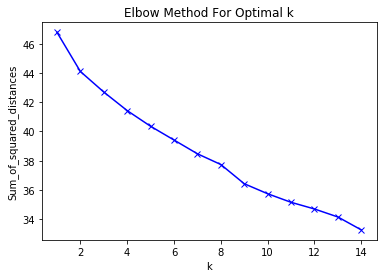

In [60]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Here we notice that the Sum of square distaces to the centroids of the clusters is decreasing starting around k=10, so we will use 10 as an optimal number for the clustering

In [61]:
# run k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(ny_t_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_.shape

(396,)

In [196]:
#neighborhoods_venues_sorted.drop('Cluster Labels',axis=1, inplace=True)

In [63]:
neighborhoods_venues_sorted.shape

(396, 11)

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_t_merged = df_NY_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_t_merged = ny_t_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner').drop_duplicates()
#x=neighborhoods_venues_sorted.join(ny_t_merged.set_index('Neighborhood'), on='Neighborhood')
x = pd.merge( neighborhoods_venues_sorted,ny_t_merged, how='inner', on=['Neighborhood']).drop_duplicates()

ny_t_merged.head() # check the last columns!

,Borough,City,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Toronto,43.806686,-79.194353,Parkwoods,3,Fast Food Restaurant,Women's Store,Farm,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
1,North York,Toronto,43.784535,-79.160497,Victoria Village,3,Bar,Women's Store,Farm,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
2,Downtown Toronto,Toronto,43.763573,-79.188711,"Regent Park, Harbourfront",3,Breakfast Spot,Rental Car Location,Bank,Medical Center,Mexican Restaurant,Restaurant,Electronics Store,Intersection,Factory,Food & Drink Shop
3,North York,Toronto,43.770992,-79.216917,"Lawrence Manor, Lawrence Heights",3,Coffee Shop,Soccer Field,Korean Restaurant,Duty-free Shop,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
4,Downtown Toronto,Toronto,43.773136,-79.239476,"Queen's Park, Ontario Provincial Government",3,Bakery,Gas Station,Hakka Restaurant,Bank,Thai Restaurant,Fried Chicken Joint,Caribbean Restaurant,Athletics & Sports,Exhibit,Event Space


In [70]:
ny_t_merged.shape

(405, 16)

In [71]:
ny_t_merged.isnull().values.sum()

0

In [72]:
ny_t_merged.dropna(inplace=True)
ny_t_merged.shape

(405, 16)

In [73]:
ny_t_merged['Cluster Labels']=ny_t_merged['Cluster Labels'].astype(int)

In [74]:
ny_t_merged.head()

,Borough,City,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Toronto,43.806686,-79.194353,Parkwoods,3,Fast Food Restaurant,Women's Store,Farm,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
1,North York,Toronto,43.784535,-79.160497,Victoria Village,3,Bar,Women's Store,Farm,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
2,Downtown Toronto,Toronto,43.763573,-79.188711,"Regent Park, Harbourfront",3,Breakfast Spot,Rental Car Location,Bank,Medical Center,Mexican Restaurant,Restaurant,Electronics Store,Intersection,Factory,Food & Drink Shop
3,North York,Toronto,43.770992,-79.216917,"Lawrence Manor, Lawrence Heights",3,Coffee Shop,Soccer Field,Korean Restaurant,Duty-free Shop,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
4,Downtown Toronto,Toronto,43.773136,-79.239476,"Queen's Park, Ontario Provincial Government",3,Bakery,Gas Station,Hakka Restaurant,Bank,Thai Restaurant,Fried Chicken Joint,Caribbean Restaurant,Athletics & Sports,Exhibit,Event Space


Examining the clusters in a map:

In [75]:
kclusters=k

In [195]:
#create map
map_clusters_ny = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_t_merged['Latitude'], ny_t_merged['Longitude'], ny_t_merged['Neighborhood'], ny_t_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_ny)
       
map_clusters_ny

In [194]:
map_clusters_t = folium.Map(location=[latitude_t, longitude_t], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_t_merged['Latitude'], ny_t_merged['Longitude'], ny_t_merged['Neighborhood'], ny_t_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_t)
       
map_clusters_t

#### Examining the clusters

In [78]:
g1=ny_t_merged.loc[ny_t_merged['Cluster Labels'] == 0, ny_t_merged.columns[[1,4] + list(range(5, ny_t_merged.shape[1]))]]

In [192]:
g2=ny_t_merged.loc[ny_t_merged['Cluster Labels'] == 1, ny_t_merged.columns[[1,4] + list(range(5, ny_t_merged.shape[1]))]]
g2

,City,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Toronto,Don Mills,1,Pizza Place,Bakery,Bus Line,Fried Chicken Joint,Metro Station,Gas Station,Chinese Restaurant,Noodle House,Fast Food Restaurant,Soccer Field
13,Toronto,Don Mills,1,Pizza Place,Bakery,Bus Line,Fried Chicken Joint,Metro Station,Gas Station,Chinese Restaurant,Noodle House,Fast Food Restaurant,Soccer Field
15,Toronto,St. James Town,1,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Bank,Grocery Store,Gym,Breakfast Spot,Sandwich Place,Coffee Shop,Pharmacy
24,Toronto,Central Bay Street,1,Butcher,Bank,Grocery Store,Pharmacy,Coffee Shop,Pizza Place,Falafel Restaurant,Empanada Restaurant,English Restaurant,Entertainment Service
34,Toronto,"Northwood Park, York University",1,Pizza Place,Intersection,Hockey Arena,Portuguese Restaurant,French Restaurant,Coffee Shop,Event Service,Eye Doctor,Exhibit,Event Space
35,Toronto,"East Toronto, Broadview North (Old East York)",1,Pizza Place,Gym / Fitness Center,Athletics & Sports,Gastropub,Fast Food Restaurant,Pharmacy,Intersection,Bank,Empanada Restaurant,English Restaurant
81,Toronto,"Runnymede, Swansea",1,Pizza Place,Breakfast Spot,Convenience Store,Bus Line,Farm,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
89,Toronto,"South Steeles, Silverstone, Humbergate, Jamest...",1,Pizza Place,Pub,Pharmacy,Sandwich Place,Coffee Shop,Gym,Financial or Legal Service,Ethiopian Restaurant,Duty-free Shop,Eastern European Restaurant
95,Toronto,Upper Rouge,1,Liquor Store,Café,Pet Store,Coffee Shop,Pharmacy,Pizza Place,Beer Store,Electronics Store,Empanada Restaurant,English Restaurant
99,Toronto,Church and Wellesley,1,Middle Eastern Restaurant,Pizza Place,Sandwich Place,Coffee Shop,Discount Store,Chinese Restaurant,Intersection,Fish Market,Exhibit,Egyptian Restaurant


In [193]:
g3=ny_t_merged.loc[ny_t_merged['Cluster Labels'] == 2, ny_t_merged.columns[[1,4] + list(range(5, ny_t_merged.shape[1]))]]
g3

,City,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
296,New York,Brookville,2,Deli / Bodega,Women's Store,Farmers Market,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
305,New York,Grymes Hill,2,Dog Run,Deli / Bodega,Women's Store,Farmers Market,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space


In [81]:
g4=ny_t_merged.loc[ny_t_merged['Cluster Labels'] == 3, ny_t_merged.columns[[1,4] + list(range(5, ny_t_merged.shape[1]))]]

In [82]:
g5=ny_t_merged.loc[ny_t_merged['Cluster Labels'] == 4, ny_t_merged.columns[[1,4] + list(range(5, ny_t_merged.shape[1]))]]

In [93]:
groups=pd.concat([g1,g2,g3,g4,g5])[['City','Cluster Labels']]

In [94]:
groups

,City,Cluster Labels
14,Toronto,0
23,Toronto,0
25,Toronto,0
30,Toronto,0
44,Toronto,0
50,Toronto,0
74,Toronto,0
98,Toronto,0
130,New York,0
295,New York,0


In [121]:
g=pd.pivot_table(groups,'City', ['Cluster Labels'],aggfunc=len, fill_value=0)

In [122]:
g

,City
Cluster Labels,
0,11
1,96
2,2
3,292
4,4


In [136]:
g11=pd.pivot_table(g1,'Cluster Labels', ['City'],aggfunc=len, fill_value=0)
g11.rename(columns={"Cluster Labels": "Cluster 1"}, inplace=True)
g11

,Cluster 1
City,
New York,3
Toronto,8


In [137]:
g22=pd.pivot_table(g2,'Cluster Labels', ['City'],aggfunc=len, fill_value=0)
g22.rename(columns={"Cluster Labels": "Cluster 2"}, inplace=True)
g22


,Cluster 2
City,
New York,84
Toronto,12


In [148]:
g33=pd.pivot_table(g3,'Cluster Labels', ['City'],aggfunc=len, fill_value=0)
g33.rename(columns={"Cluster Labels": "Cluster 3"}, inplace=True)
g33

,Cluster 3
City,
New York,2


In [139]:
g44=pd.pivot_table(g4,'Cluster Labels', ['City'],aggfunc=len, fill_value=0)
g44.rename(columns={"Cluster Labels": "Cluster 4"}, inplace=True)
g44

,Cluster 4
City,
New York,215
Toronto,77


In [141]:
g55=pd.pivot_table(g5,'Cluster Labels', ['City'],aggfunc=len, fill_value=0)
g55.rename(columns={"Cluster Labels": "Cluster 5"}, inplace=True)
g55

,Cluster 5
City,
New York,1
Toronto,3


In [175]:
G=g11.merge(g22, on='City').merge(g33, on='City', how='outer').merge(g44, on='City').merge(g55, on='City')
G.fillna(0, inplace=True)

In [176]:
G.astype(int, inplace=True)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
City,,,,,
New York,3,84,2,215,1
Toronto,8,12,0,77,3


In [177]:
G['sum']=G.sum(axis=1)

In [187]:
G_percent=G.loc[:,"Cluster 1":"Cluster 5"].div(G["sum"], axis=0).round(3)*100

In [188]:
G_percent

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
City,,,,,
New York,1.0,27.5,0.7,70.5,0.3
Toronto,8.0,12.0,0.0,77.0,3.0


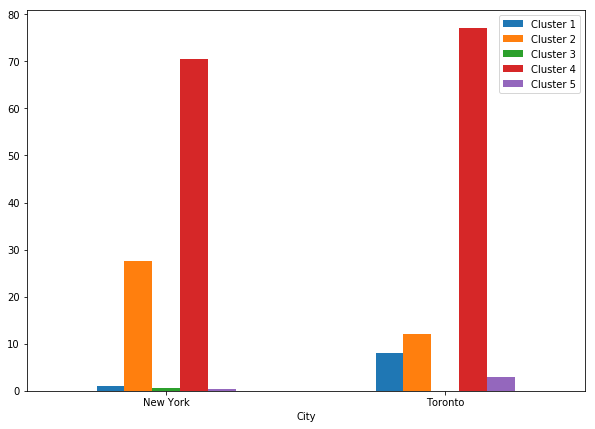

In [191]:
ax = G_percent.plot.bar(rot=0,figsize=(10,7))